In [2]:
import pandas as pd
import main
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

In [3]:
ercot = main.build_ercot_load()
ercot_dd = pd.read_csv("ercot_degree_days.csv", index_col="Date", parse_dates=["Date"])
ercot_total = ercot.join(ercot_dd, on="DATE")

/var/folders/98/9n7hhtwj2rv2jdkkj2fmm52r0000gn/T/ipykernel_54884/2070109814.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ercot_dd = pd.read_csv("ercot_degree_days.csv", index_col="Date", parse_dates=["Date"])


In [28]:
mstl = MSTL(ercot.set_index("DATETIME")["ERCOT"],
            periods=[24, 24 * 7, 365 * 24], iterate=3, windows=[11, 15, 9999],
            stl_kwargs={"seasonal_deg": 0,
                        "inner_iter": 2,
                        "outer_iter": 0})
res = mstl.fit()

In [41]:
pd.pivot_table(res.seasonal[["seasonal_8760"]].shift(-2),
               index=[res.seasonal["seasonal_8760"].index.dayofyear,
                      res.seasonal["seasonal_8760"].index.hour],
               columns=res.seasonal["seasonal_8760"].index.year)

seasonal_8760                                         \
DATETIME                   2018         2019         2020         2021   
DATETIME DATETIME                                                        
1        0                  NaN -2901.579905 -2901.579905 -1876.259860   
         1         -3015.943911 -3015.943913 -3015.943913 -2080.878951   
         2         -3198.268941 -3198.268942 -3198.268942 -2285.383079   
         3         -3483.366088 -3483.366090 -3483.366090 -2524.437816   
         4         -4092.215370 -4092.215371 -4092.215371 -2857.558814   
...                         ...          ...          ...          ...   
366      19                 NaN          NaN -3278.514032          NaN   
         20                 NaN          NaN -3532.329192          NaN   
         21                 NaN          NaN -3579.598394          NaN   
         22                 NaN          NaN -3494.796199          NaN   
         23                 NaN          NaN -1825.347009          NaN   

                                             
DATETIME                  2022         2023  
DATETIME DATETIME                            
1        0        -1876.259860 -1876.259860  
         1        -2080.878951 -2080.878951  
         2        -2285.383079 -2285.383079  
         3        -2524.437816 -2524.437816  
         4        -2857.558814 -2857.558814  
...                        ...          ...  
366      19                NaN          NaN  
         20                NaN          NaN  
         21                NaN          NaN  
         22                NaN          NaN  
         23                NaN          NaN  

[8784 rows x 6 columns]

In [136]:
res.seasonal["seasonal_8760"].head(8760).index

DatetimeIndex(['2018-01-01 01:00:00', '2018-01-01 02:00:00',
               '2018-01-01 03:00:00', '2018-01-01 04:00:00',
               '2018-01-01 05:00:00', '2018-01-01 06:00:00',
               '2018-01-01 07:00:00', '2018-01-01 08:00:00',
               '2018-01-01 09:00:00', '2018-01-01 10:00:00',
               ...
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00',
               '2018-12-31 21:00:00', '2018-12-31 22:00:00',
               '2018-12-31 23:00:00', '2019-01-01 00:00:00'],
              dtype='datetime64[ns]', name='DATETIME', length=8760, freq=None)

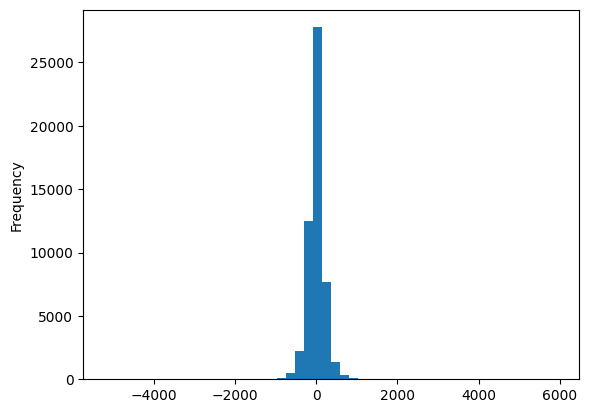

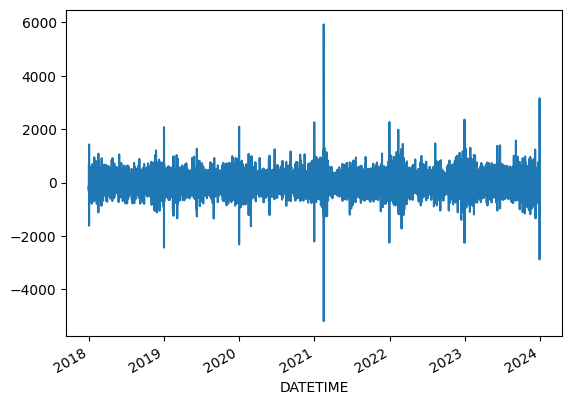

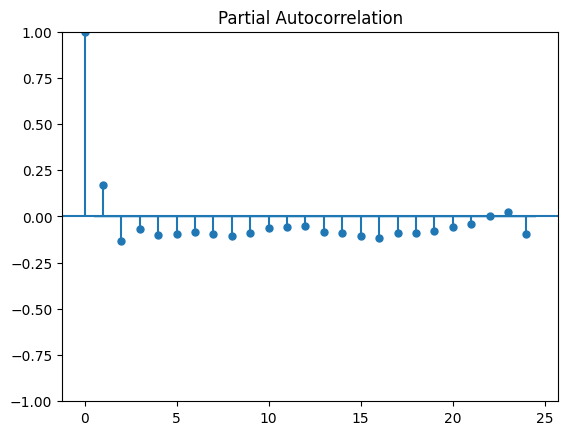

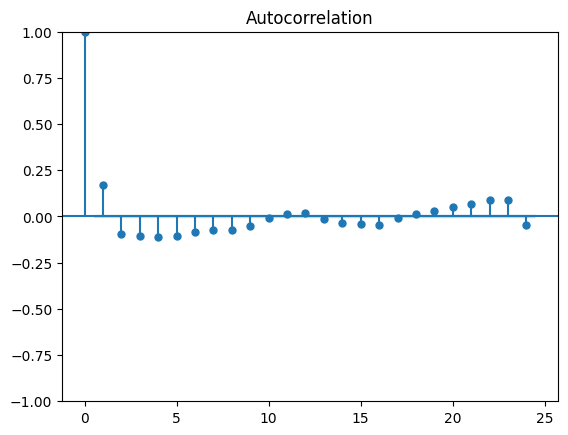

In [56]:
extra = (res.trend + res.resid).diff().diff().dropna()
extra.plot.hist(bins=50)
plt.show()
extra.plot()
plt.show()
sm.graphics.tsa.plot_pacf(extra, lags=24, alpha=.05)
plt.savefig("resid_pacf.png")
sm.graphics.tsa.plot_acf(extra, lags=24, alpha=.05)
plt.savefig("resid_acf.png")

In [ ]:
mod = ARIMA(res.seasonal["seasonal_24"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted = mod.fit(method='innovations_mle', low_memory=True, cov_type='none')

In [ ]:
plt.plot(res.resid)
plt.show()

In [ ]:
pred = fitted.predict(start=52583+1, end=52583+24*7)
res.seasonal["seasonal_168"].tail(24*14).plot()
pred.plot()
plt.show()

In [ ]:
sm.graphics.tsa.plot_pacf(res.resid.diff().dropna(), lags=24*5, alpha=.05)
plt.show()

In [ ]:
res.resid.diff().dropna()

In [ ]:
ax = res.plot()
plt.tight_layout()

In [ ]:
sm.graphics.tsa.plot_acf(res.resid.diff().dropna(), lags=24*3, alpha=.05)
plt.savefig("coast acf.png")

In [ ]:
ercot[["DATETIME", "NO"]].head(24*7).set_index("DATETIME")["ERCOT"].plot()
plt.title("ERCOT Hourly Load")
plt.xlabel("Date")
plt.ylabel("Load(MWs)")
plt.savefig("ERCOT HOURLY.png")

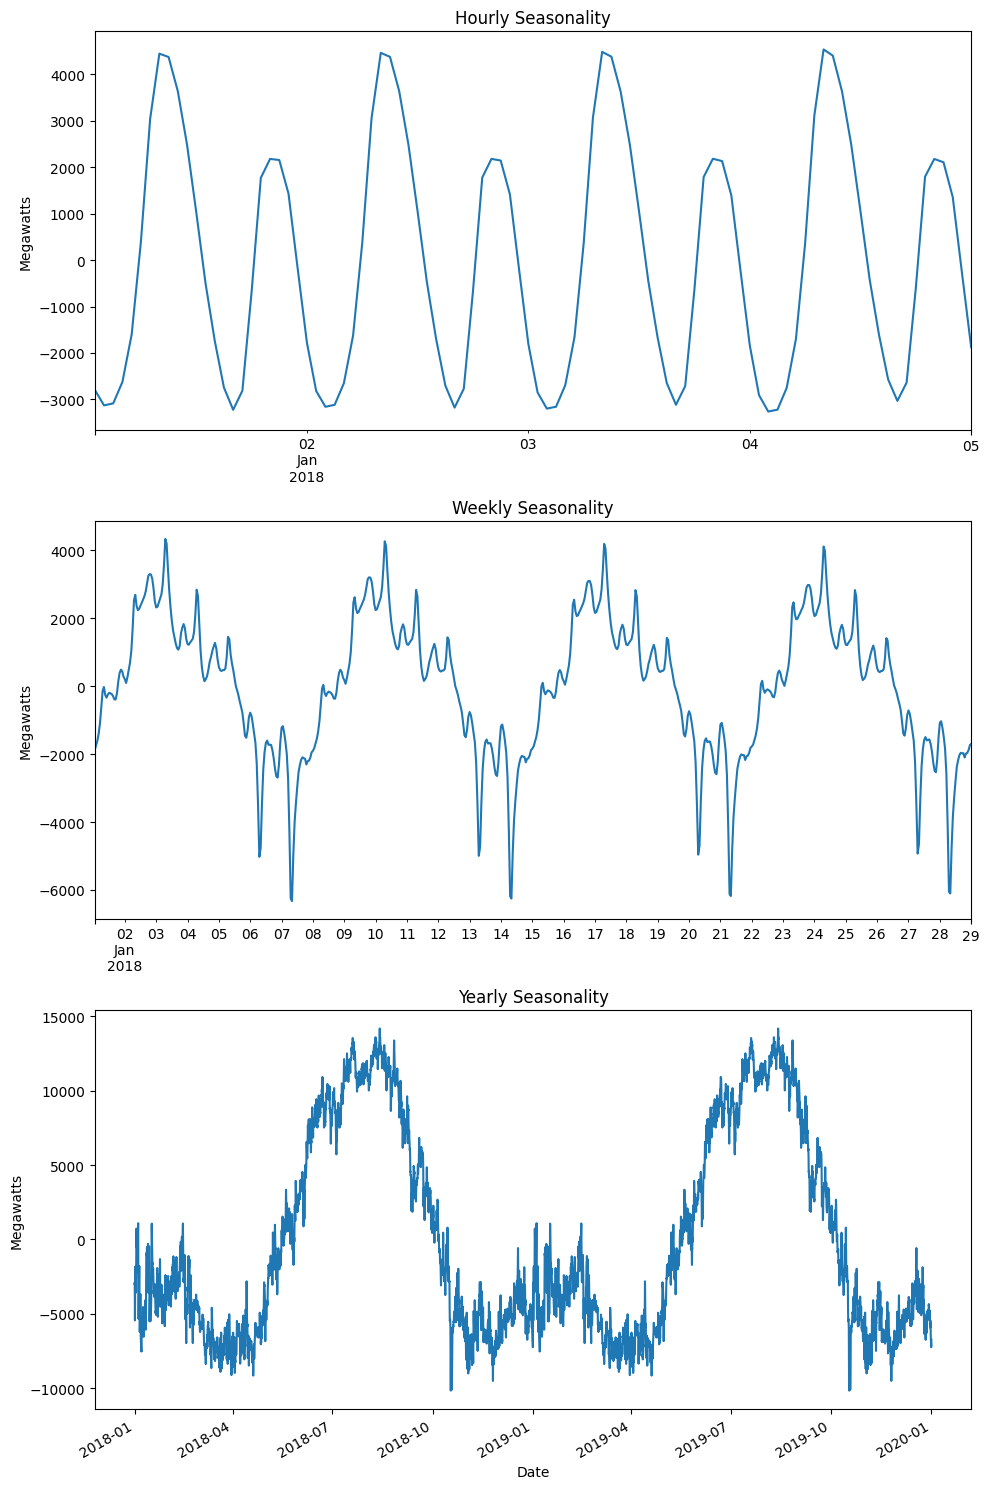

In [140]:
fig, ax = plt.subplots(nrows=3, figsize=[10,15])

res.seasonal.head(24*4)["seasonal_24"].plot(ax=ax[0], title="Hourly Seasonality",
                                            ylabel="Megawatts")
res.seasonal.head(168*4)["seasonal_168"].plot(ax=ax[1], title="Weekly Seasonality",
                                                ylabel="Megawatts")
res.seasonal.head(8760*2)["seasonal_8760"].plot(ax=ax[2], title="Yearly Seasonality",
                                              ylabel="Megawatts",
                                              xlabel="Date")
ax[0].set(xlabel=None)
ax[1].set(xlabel=None)
plt.tight_layout()
plt.savefig("ercot_seasonality.png")

In [ ]:
res.seasonal.corr()

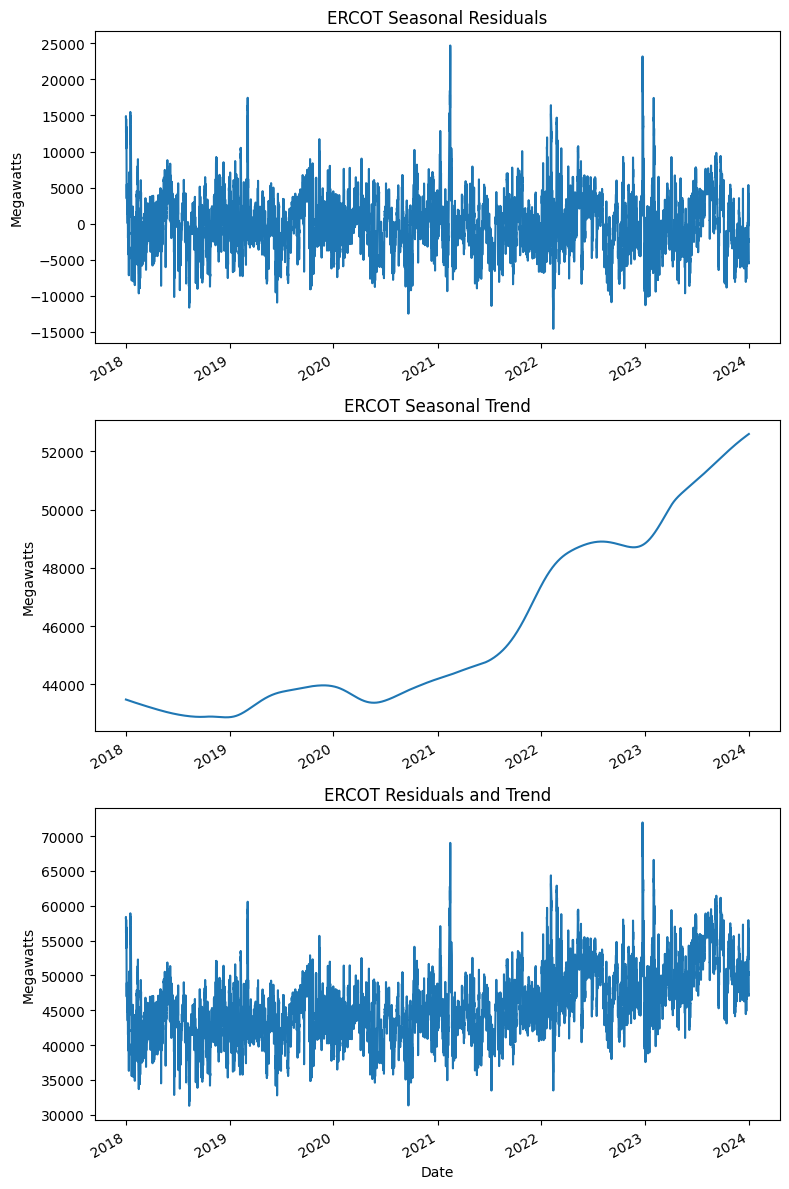

In [145]:
fig, ax = plt.subplots(nrows=3, figsize=[8, 12])

res.resid.plot(ax=ax[0], title="ERCOT Seasonal Residuals", ylabel="Megawatts")
res.trend.plot(ax=ax[1], title="ERCOT Seasonal Trend", xlabel="Date", ylabel="Megawatts")
(res.trend + res.resid).plot(ax=ax[2], title="ERCOT Residuals and Trend", xlabel="Date", ylabel="Megawatts")
ax[0].set(xlabel=None)
ax[1].set(xlabel=None)
plt.tight_layout()
plt.savefig("ercot_seasonal_trend.png")

In [ ]:
adfuller(ercot["ERCOT"].diff().dropna())

In [ ]:
seas_shift = res.seasonal
seas_shift.index = seas_shift.index.shift(freq="-1H")

In [ ]:
pivoted_year = pd.pivot_table(res.seasonal[["seasonal_8760"]], columns=res.seasonal.index.year, index=[res.seasonal.index.dayofyear, res.seasonal.index.hour])["seasonal_8760"]

pivoted_day = pd.pivot_table(seas_shift[["seasonal_24"]], columns=[res.seasonal.index.dayofyear, res.seasonal.index.year], index=res.seasonal.index.hour)["seasonal_24"]

In [ ]:
pivoted_day[330].plot()
plt.show()

In [ ]:
pivoted_year.plot()

In [ ]:
res.seasonal["seasonal_8760"].groupby(res.seasonal.index.dayofyear).mean().plot()

In [ ]:
pivoted_week = pd.pivot_table(seas_shift[["seasonal_168"]],
                              index=res.seasonal.index.dayofweek * 24 + res.seasonal.index.hour,
                              columns=[res.seasonal.index.isocalendar().week])["seasonal_168"]

In [ ]:
pivoted_week.plot(legend=False, title="Weekly Seasonal Shape Patterns in COAST", ylabel="Weekly Component(MWs)", xlabel="Hour of Week")
plt.show()

In [ ]:
pivoted_week[0].plot()

In [ ]:
seas_shift.corr()

In [ ]:
seas_resid = pd.DataFrame(data=res.resid.values, index=res.resid.index, columns=["RESID"])
seas_resid.index = pd.to_datetime(seas_resid.index)
seas_resid["DATE"] = pd.to_datetime(seas_resid.index.date)
seas_resid = seas_resid.join(ercot_dd, on="DATE")

In [ ]:
seas_resid.corr()

In [ ]:
houston_weather = pd.read_csv("houston_weather_2023.csv", index_col="DATETIME")
houston_weather.index = pd.to_datetime(houston_weather.index)
houston_weather.index = houston_weather.index.shift(freq="7MIN")

In [ ]:
ercot["COAST RESID"] = res.resid

In [ ]:
houston_all = ercot.merge(houston_weather, how="inner", left_on="DATETIME", right_on="DATETIME").iloc[:,-8:].dropna()

In [ ]:
houston_all["COAST RESID"]

In [ ]:
exog = pd.DataFrame(index=ercot.index)
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog['sin24'] = np.sin(2 * np.pi * exog.index.hour / 24)
exog['cos24'] = np.cos(2 * np.pi * exog.index.hour / 24)
exog['sin24_2'] = np.sin(4 * np.pi * exog.index.hour / 24)
exog['cos24_2'] = np.cos(4 * np.pi * exog.index.hour / 24)

exog['sin168'] = np.sin(2 * np.pi * ((exog.index.dayofweek * 24) + exog.index.hour) / 168)
exog['cos168'] = np.cos(2 * np.pi * ((exog.index.dayofweek * 24) + exog.index.hour) / 168)
exog['sin168_2'] = np.sin(4 * np.pi * ((exog.index.dayofweek * 24) + exog.index.hour) / 168)
exog['cos168_2'] = np.cos(4 * np.pi * ((exog.index.dayofweek * 24) + exog.index.hour) / 168)

In [ ]:
exog_to_train = exog.iloc[:(len(ercot)-365*24)]
exog_to_test = exog.iloc[(len(ercot)-365*24):]
y_to_train = ercot.iloc[:(len(ercot)-365*24)]["ERCOT"]
y_to_test = ercot.iloc[(len(ercot)-365*24):]["ERCOT"]
arima_exog_model = auto_arima(y=y_to_train, exogenous=exog_to_train, seasonal=False)

In [ ]:
plt.plot(arima_exog_model.predict(n_periods=30, exogenous=exog_to_test).values)
plt.plot(y_to_test.head(30).values)
plt.show()

In [ ]:
daily_arima = auto_arima(y=res.seasonal["seasonal_24"].tail(365*2), seasonal=True, m=24, max_p=2, max_d=1, max_q=2)

In [ ]:
daily_pred = daily_arima.predict(n_periods=24*2)
res.seasonal["seasonal_24"].tail(24*5).plot()
daily_pred.plot()

In [ ]:
res.seasonal["seasonal_8760"].plot()

In [104]:
history = {}

[0.46441776 0.46210211 0.46352707 0.46892966 0.47644995 0.49251482
 0.51382443 0.51315401 0.4935881  0.4722176  0.44959712 0.43484925
 0.43137642 0.43366798 0.43644849 0.43889656 0.43378082 0.42289373
 0.4147121  0.40160988 0.39264831 0.38809878 0.38908893 0.39695554]
0.40549002831479075
[0.46210211 0.46352707 0.46892966 0.47644995 0.49251482 0.51382443
 0.51315401 0.4935881  0.4722176  0.44959712 0.43484925 0.43137642
 0.43366798 0.43644849 0.43889656 0.43378082 0.42289373 0.4147121
 0.40160988 0.39264831 0.38809878 0.38908893 0.39695554 0.40549003]
0.41217139770703104
[0.46352707 0.46892966 0.47644995 0.49251482 0.51382443 0.51315401
 0.4935881  0.4722176  0.44959712 0.43484925 0.43137642 0.43366798
 0.43644849 0.43889656 0.43378082 0.42289373 0.4147121  0.40160988
 0.39264831 0.38809878 0.38908893 0.39695554 0.40549003 0.4121714 ]
0.41295607296994663
[0.46892966 0.47644995 0.49251482 0.51382443 0.51315401 0.4935881
 0.4722176  0.44959712 0.43484925 0.43137642 0.43366798 0.43644849
 

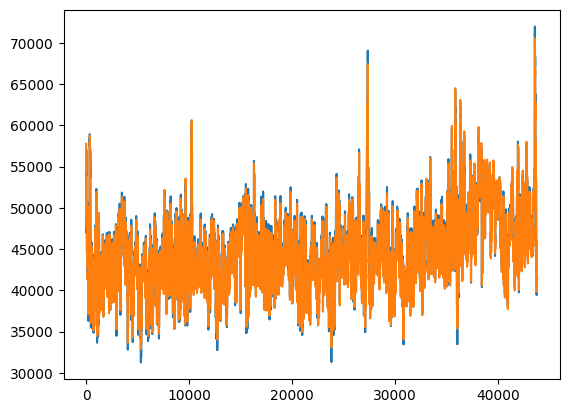

In [128]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

trend_resid = pd.DataFrame(res.trend + res.resid, columns=["ERCOT"])
train = trend_resid.iloc[:(len(trend_resid) - 365 * 24)]
test = trend_resid.iloc[(len(trend_resid) - 365 * 24):]

scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

timesteps = 25

train_data_timesteps = np.array([[j for j in train[i:i+timesteps]] for i in range(0,len(train)-timesteps+1)])[:,:,0]

test_data_timesteps = np.array([[j for j in test[i:i+timesteps]] for i in range(0,len(test)-timesteps+1)])[:,:,0]

x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

model = SVR(kernel='rbf', gamma=0.5, C=10, epsilon=0.05)
model.fit(x_train, y_train[:,0])

y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

next_in = np.roll(x_test[-1], -1)
next_in[-1] = y_test_pred[-1]

for _ in range(5):
    print(next_in)
    next_pred = model.predict(next_in.reshape(1, -1))[0]
    print(next_pred)
    next_in = np.roll(next_in, -1)
    next_in[-1] = next_pred


y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

plt.plot(y_train)
plt.plot(y_train_pred)
plt.show()
mape_train = mean_absolute_percentage_error(y_train_pred, y_train) * 100
mape_test = mean_absolute_percentage_error(y_test_pred, y_test) * 100
history[timesteps] = {"train": mape_train, "test": mape_test}

In [117]:
history

{13: {'train': 1.0163129840654432, 'test': 0.6951378432118298},
 17: {'train': 1.0720752183460176, 'test': 0.730641383028769},
 21: {'train': 1.1003752659285726, 'test': 0.8677131300933697},
 25: {'train': 0.9618136165840545, 'test': 0.8331774380351941},
 29: {'train': 0.9234032429818916, 'test': 0.878862875908998},
 11: {'train': 1.0085817589752646, 'test': 0.7199109137969674},
 9: {'train': 1.1166155987960977, 'test': 0.7175023876271749},
 14: {'train': 1.052894735005157, 'test': 0.6881011542764757},
 15: {'train': 1.1592665971676863, 'test': 0.7091638951090731}}